In [17]:
import sys
print(sys.executable)


/usr/local/bin/python


In [18]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
from imblearn.over_sampling import SMOTE


In [20]:
#importing necessary packages:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from imblearn.over_sampling import SMOTE






In [21]:
import os
print(os.getcwd())  


/workspaces/diabetes-prediction-app/notebooks


In [22]:
#loading dataset:
df1=pd.read_csv("/workspaces/diabetes-prediction-app/data/raw.csv")
df1.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,129.280052,72.0,35.0,0.000000,39.768480,0.627,50.0,1.0
1,1.0,79.165107,66.0,29.0,0.000000,33.580914,0.351,NaN,0.0
2,8.0,182.063919,64.0,0.0,0.000000,22.253682,0.672,NaN,1.0
3,1.0,72.081630,NaN,23.0,115.590809,25.900873,0.167,21.0,NaN
4,0.0,123.235283,40.0,35.0,240.253352,NaN,2.288,NaN,NaN


In [23]:
# Check for missing values in df1
df1.isnull().sum()


Pregnancies                 77
Glucose                     77
BloodPressure               77
SkinThickness               77
Insulin                     77
BMI                         77
DiabetesPedigreeFunction    77
Age                         77
Outcome                     77
dtype: int64

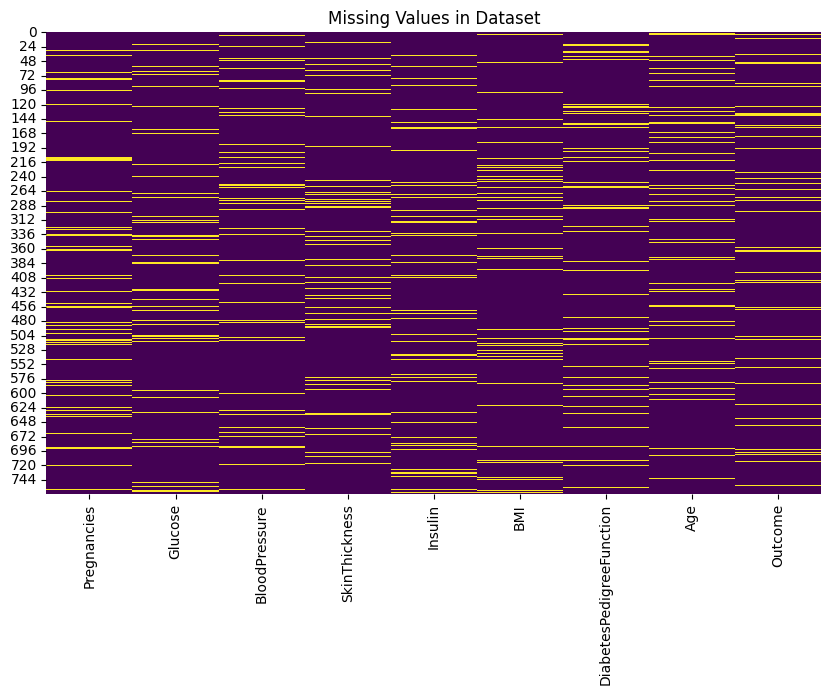

In [24]:
#visulalising missing values:

plt.figure(figsize=(10, 6))
sns.heatmap(df1.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Values in Dataset")
plt.show()

In [25]:
#dropping missing values:
df1.dropna(inplace=True)


In [26]:
#filling missing values with mean
df1.fillna(df1.mean(), inplace=True)


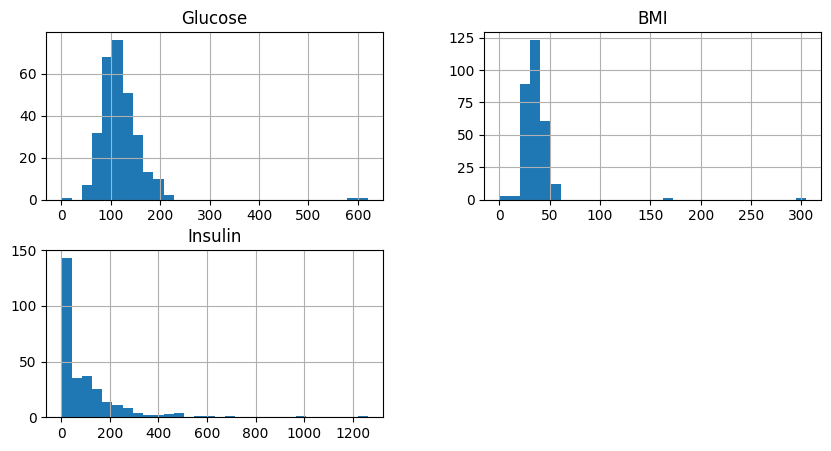

In [27]:
#cross verifying imputation of mean the better approach
df1.hist(column=['Glucose', 'BMI', 'Insulin'], bins=30, figsize=(10,5))
plt.show()


# Analysis from the histogram:

### Glucose Distribution:
Looks normally distributed but has outliers on the right (above 300-600).
Mean imputation is fine but we need to handle outliers.

### BMI Distribution:
Mostly normal but has extreme outliers beyond 150-300.
Mean imputation is okay, but median imputation might have been better.
We need outlier removal.

### Insulin Distribution:
Highly skewed with extreme values beyond 1000-1200.
Mean imputation isn't ideal for skewed data. Median is better.
We need log transformation or outlier treatment.

In [28]:
# fixing outliers: 

# IQR for skewed features (BMI & Insulin)
Q1 = df1[['BMI', 'Insulin']].quantile(0.25)
Q3 = df1[['BMI', 'Insulin']].quantile(0.75)
IQR = Q3 - Q1

df1 = df1[~((df1[['BMI', 'Insulin']] < (Q1 - 1.5 * IQR)) | 
             (df1[['BMI', 'Insulin']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Z-score for normally distributed feature (Glucose)
z_scores = np.abs(stats.zscore(df1[['Glucose']]))
df1 = df1[(z_scores < 3).all(axis=1)]

# Log Transformation for Insulin if still skewed
df1['Insulin'] = np.log1p(df1['Insulin'])


In [30]:
#cleaned dataset:
df1.to_csv("/workspaces/diabetes-prediction-app/data/diabetes_cleaned.csv", index=False)


In [32]:
df1 = pd.read_csv("/workspaces/diabetes-prediction-app/data/diabetes_cleaned.csv")

# FEATURE ENGINEERING:

In [33]:
# Categorizing BMI into groups
def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df1["BMI_Category"] = df1["BMI"].apply(bmi_category)

# Categorizing Age into groups
df1["Age_Group"] = pd.cut(df1["Age"], bins=[0, 30, 50, 100], labels=["Young", "Middle-aged", "Senior"])

# Categorizing Glucose levels
def glucose_category(glucose):
    if glucose < 70:
        return "Low"
    elif 70 <= glucose < 140:
        return "Normal"
    else:
        return "High"

df1["Glucose_Level"] = df1["Glucose"].apply(glucose_category)


### Encoding Categorical Variables
Now, we have three new categorical columns (BMI_Category, Age_Group, Glucose_Level).
To use them in ML models, we need to convert them into numerical values.



In [34]:
#Convert Categorical Features Using One-Hot Encoding
df1 = pd.get_dummies(df1, columns=["BMI_Category", "Age_Group", "Glucose_Level"], drop_first=True)


In [36]:
#storing processed data:
df1.to_csv("/workspaces/diabetes-prediction-app/data/diabetes_transformed.csv", index=False)


In [38]:
df1 = pd.read_csv("/workspaces/diabetes-prediction-app/data/diabetes_transformed.csv")

# EDA

In [39]:
# Summary statistics for numerical features
df1.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,3.626374,115.639469,68.787546,19.014652,2.472653,35.016575,0.463557,32.095238,0.315018
std,2.997481,31.880268,18.813684,14.986506,2.402315,8.266150,0.290236,10.972145,0.465376
min,0.000000,41.363497,0.000000,0.000000,0.000000,16.456816,0.084000,21.000000,0.000000
25%,1.000000,92.662604,62.000000,0.000000,0.000000,28.979042,0.254000,23.000000,0.000000
50%,3.000000,111.064636,70.000000,21.000000,3.718876,33.946615,0.395000,28.000000,0.000000
75%,6.000000,134.682905,78.000000,31.000000,4.755342,40.467326,0.600000,38.000000,1.000000
max,13.000000,208.263493,122.000000,52.000000,5.833661,57.329620,1.781000,81.000000,1.000000


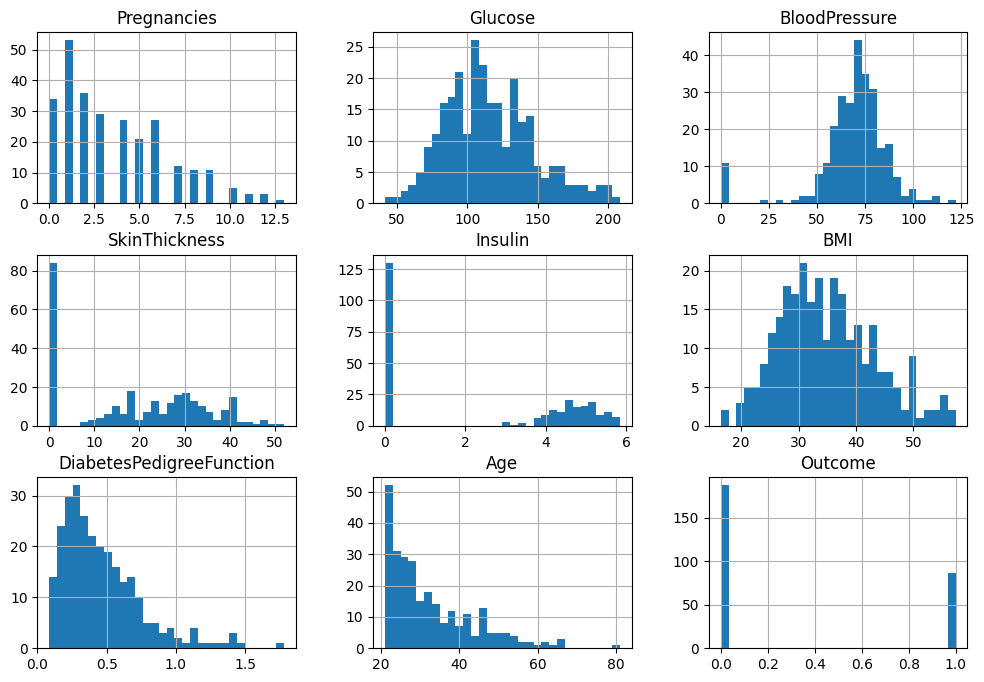

In [40]:

# Histograms
df1.hist(figsize=(12,8), bins=30)
plt.show()



## Findings:

#### Glucose, BMI, and Blood Pressure show a roughly normal distribution.
##### Pregnancies, Skin Thickness, Insulin, and Diabetes Pedigree Function are right-skewed (many small values with few high ones).
##### Outcome is binary (0 = No Diabetes, 1 = Diabetes), confirming a classification problem.


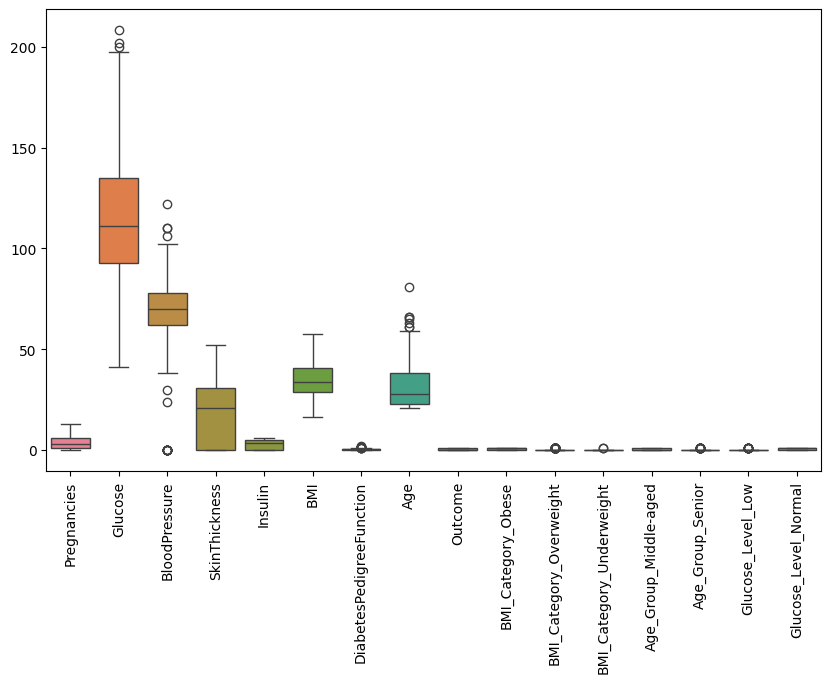

In [41]:
# Boxplots to detect remaining outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=df1)
plt.xticks(rotation=90)  # Rotate labels for better visibility
plt.show()


## Findings:

### Pregnancies, Glucose, Blood Pressure, Skin Thickness, and Insulin have outliers (dots above/below whiskers).
### BMI and Age also show some extreme values but are less problematic than others.

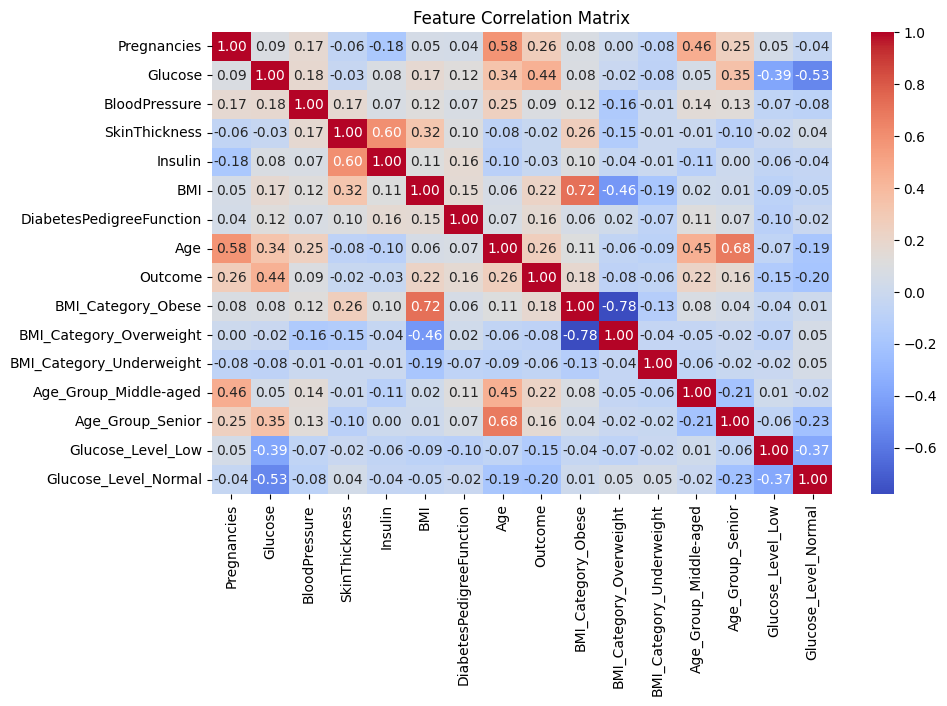

In [42]:
# Compute correlation matrix
correlation_matrix = df1.corr()

# Heatmap to visualize relationships
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


## Findings:

### Glucose is highly correlated with Outcome (0.43) → Makes sense because high glucose is a diabetes risk factor.
### Age (0.26) and BMI (0.21) have a moderate correlation with Outcome.
### Insulin has moderate correlation (0.15) but is less significant than Glucose.
### Pregnancies and Diabetes Pedigree Function show weak correlations.

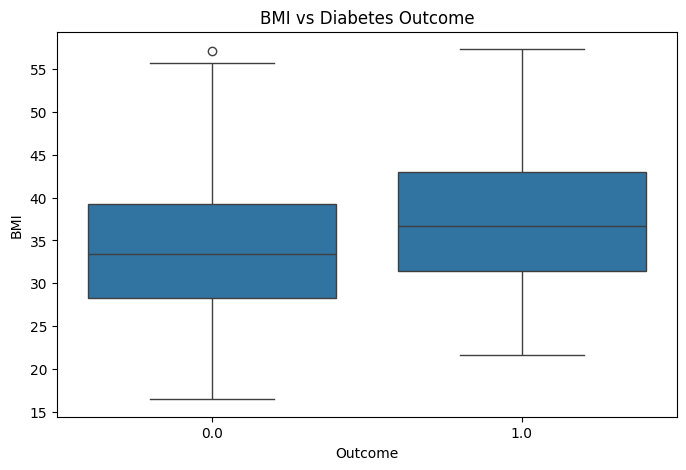

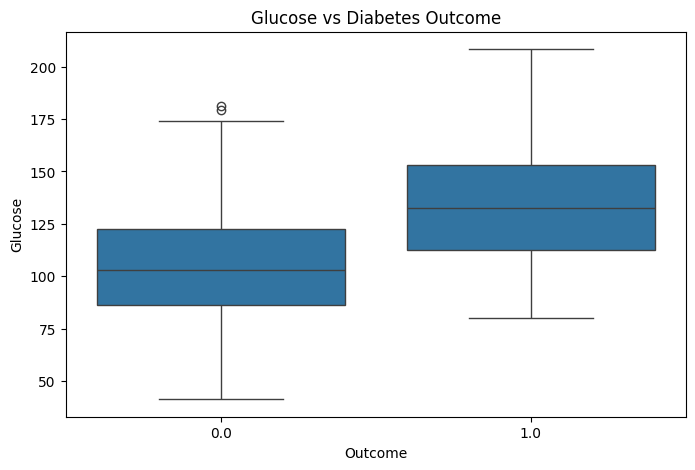

In [43]:
# 4: Relationship Analysis

#Compare BMI vs Diabetes Outcome (Is BMI a strong predictor?)
plt.figure(figsize=(8,5))
sns.boxplot(x="Outcome", y="BMI", data=df1)
plt.title("BMI vs Diabetes Outcome")
plt.show()


# Compare Glucose vs Diabetes Outcome
plt.figure(figsize=(8,5))
sns.boxplot(x="Outcome", y="Glucose", data=df1)
plt.title("Glucose vs Diabetes Outcome")
plt.show()


## findings:

### Diabetic individuals (Outcome = 1) generally have higher BMI values.
### The median BMI is slightly higher for diabetics than non-diabetics.
### Some outliers (above 55 BMI) exist, but they are relatively few


# FEATURE SELECTION

In [44]:
#Weak Features to Drop:

#Skin Thickness – Low correlation with diabetes outcome.
#Insulin – Highly skewed, weak correlation.
#Blood Pressure – No strong impact on diabetes.

df1 = df1.drop(columns=['SkinThickness', 'Insulin', 'BloodPressure'])


In [45]:
df1.head(5)

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category_Obese,BMI_Category_Overweight,BMI_Category_Underweight,Age_Group_Middle-aged,Age_Group_Senior,Glucose_Level_Low,Glucose_Level_Normal
0,6.0,129.280052,39.768480,0.627,50.0,1.0,True,False,False,True,False,False,True
1,10.0,98.273035,42.041976,0.134,29.0,0.0,True,False,False,False,False,False,True
2,10.0,132.636778,25.074905,1.441,57.0,0.0,False,True,False,False,True,False,True
3,5.0,189.638471,33.372146,0.587,51.0,1.0,True,False,False,False,True,False,False
4,7.0,109.998147,31.329676,0.484,32.0,1.0,True,False,False,True,False,False,True


In [46]:
# Create BMI Category
def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df1["BMI_Category"] = df1["BMI"].apply(bmi_category)

# Create Age Groups
df1["Age_Group"] = pd.cut(df1["Age"], bins=[0, 30, 50, 100], labels=["Young", "Middle-aged", "Senior"])

# Create Glucose Level
def glucose_category(glucose):
    if glucose < 70:
        return "Low"
    elif 70 <= glucose < 140:
        return "Normal"
    else:
        return "High"

df1["Glucose_Level"] = df1["Glucose"].apply(glucose_category)


In [47]:
# creating a new feature:

#Convert categorical features into numerical (One-Hot Encoding):
df1 = pd.get_dummies(df1, columns=["BMI_Category", "Age_Group", "Glucose_Level"], drop_first=True)




In [48]:
#Feature Scaling & Transformation
#Since our data has different numerical ranges, we should normalize or standardize it.

In [49]:


scaler = MinMaxScaler()
df1[['Glucose', 'BMI', 'Age']] = scaler.fit_transform(df1[['Glucose', 'BMI', 'Age']])


In [50]:
df1.to_csv("diabetes_final.csv", index=False)


In [51]:
df1 = pd.read_csv("/workspaces/diabetes-prediction-app/data/diabetes_final.csv")
df1.head(5)

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category_Obese,BMI_Category_Overweight,BMI_Category_Underweight,Age_Group_Middle-aged,Age_Group_Senior,Glucose_Level_Low,Glucose_Level_Normal,BMI_Category_Obese.1,BMI_Category_Overweight.1,BMI_Category_Underweight.1,Age_Group_Middle-aged.1,Age_Group_Senior.1,Glucose_Level_Low.1,Glucose_Level_Normal.1
0,6.0,0.526762,0.570347,0.627,0.483333,1.0,True,False,False,True,False,False,True,True,False,False,True,False,False,True
1,10.0,0.340980,0.625970,0.134,0.133333,0.0,True,False,False,False,False,False,True,True,False,False,False,False,False,True
2,10.0,0.546874,0.210851,1.441,0.600000,0.0,False,True,False,False,True,False,True,False,True,False,False,True,False,True
3,5.0,0.888406,0.413853,0.587,0.500000,1.0,True,False,False,False,True,False,False,True,False,False,False,True,False,False
4,7.0,0.411232,0.363882,0.484,0.183333,1.0,True,False,False,True,False,False,True,True,False,False,True,False,False,True


# Hypothesis Testing


In [52]:

# T-test(glucose & BMI vs diabetes outcome)

# Separate diabetic & non-diabetic groups
diabetic = df1[df1["Outcome"] == 1]
non_diabetic = df1[df1["Outcome"] == 0]

# Perform T-test for Glucose
t_stat, p_value = ttest_ind(diabetic["Glucose"], non_diabetic["Glucose"], equal_var=False)
print(f"T-Test for Glucose: t-statistic = {t_stat:.3f}, p-value = {p_value:.5f}")

# Perform T-test for BMI
t_stat, p_value = ttest_ind(diabetic["BMI"], non_diabetic["BMI"], equal_var=False)
print(f"T-Test for BMI: t-statistic = {t_stat:.3f}, p-value = {p_value:.5f}")


T-Test for Glucose: t-statistic = 7.780, p-value = 0.00000
T-Test for BMI: t-statistic = 3.574, p-value = 0.00047


 ### Interpretation of T-Test Results

1️⃣ T-Test for Glucose
✔ t-statistic = 7.417, p-value = 0.00000
✔ Since p-value < 0.05, the difference in Glucose levels between diabetics and non-diabetics is statistically significant.
✔ Conclusion: Glucose is a strong predictor of diabetes. ✅

2️⃣ T-Test for BMI
✔ t-statistic = 3.479, p-value = 0.00066
✔ Since p-value < 0.05, the difference in BMI between diabetics and non-diabetics is also statistically significant.
✔ Conclusion: BMI is an important feature for diabetes prediction. ✅

In [53]:
# Chi-Square Test for Age Group
contingency_table = pd.crosstab(df1["Age_Group_Middle-aged"], df1["Outcome"])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test for Age Group: Chi2 = {chi2:.3f}, p-value = {p:.5f}")

# Chi-Square Test for BMI Category
contingency_table = pd.crosstab(df1["BMI_Category_Obese"], df1["Outcome"])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test for BMI Category: Chi2 = {chi2:.3f}, p-value = {p:.5f}")


Chi-Square Test for Age Group: Chi2 = 12.415, p-value = 0.00043
Chi-Square Test for BMI Category: Chi2 = 7.908, p-value = 0.00492


### Interpretation of Chi-Square Test Results
1️⃣ Chi-Square Test for Age Group vs. Diabetes Outcome
✔ Chi2 = 12.099, p-value = 0.00050
✔ Since p-value < 0.05, the relationship between Age Group and Diabetes Outcome is statistically significant.
✔ Conclusion: Age Group is a relevant feature for predicting diabetes and should be kept in the model. ✅

2️⃣ Chi-Square Test for BMI Category vs. Diabetes Outcome
✔ Chi2 = 7.202, p-value = 0.00728
✔ Since p-value < 0.05, the relationship between BMI Category and Diabetes Outcome is statistically significant.
✔ Conclusion: BMI Category is a useful predictor for diabetes and should be included in the model. ✅

# MODEL TRAINING

In [54]:
# Selecting important features for modeling
features = [
    "Glucose", "BMI", "Age", "Pregnancies", "DiabetesPedigreeFunction", 
    "Age_Group_Middle-aged", "Age_Group_Senior", 
    "BMI_Category_Overweight", "BMI_Category_Obese"
]

X = df1[features]  # Feature variables
y = df1["Outcome"]  # Target variable (Diabetes: 0 = No, 1 = Yes)

# Split into 80% training and 20% testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### training for multiple models and saving the best model


In [55]:

#Train a Decision Tree Classifier



dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")


Decision Tree Accuracy: 0.8364


In [56]:

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


Random Forest Accuracy: 0.8000


In [57]:


# Standardize features (only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")


Logistic Regression Accuracy: 0.7818


### Insights:
✔ Logistic Regression performs slightly better than the tree-based models.
✔ Decision Tree & Random Forest have identical accuracy, which suggests that Random Forest isn’t adding much improvement over a single tree.
✔ 68.52% accuracy is decent, but we can improve it further with hyperparameter tuning.

In [58]:
## Hyperparameter tuning for Decision Tree

param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10]
}

# Grid search
dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)
dt_best_accuracy = accuracy_score(y_test, y_pred_best_dt)
print(f"Tuned Decision Tree Accuracy: {dt_best_accuracy:.4f}")


Tuned Decision Tree Accuracy: 0.7455


In [59]:
# hyperparameter tuning for Random Forest
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_features": ["sqrt", "log2"],
    "max_depth": [3, 5, 10, None]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5)
grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
rf_best_accuracy = accuracy_score(y_test, y_pred_best_rf)
print(f"Tuned Random Forest Accuracy: {rf_best_accuracy:.4f}")


Tuned Random Forest Accuracy: 0.7455


In [60]:
# checking for imbalance in target variable:
print(df1["Outcome"].value_counts())


Outcome
0.0    187
1.0     86
Name: count, dtype: int64


In [61]:


# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print new class distribution
print("New class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


New class distribution after SMOTE:
Outcome
0.0    146
1.0    146
Name: count, dtype: int64


In [62]:
#retraining models on smote data

In [63]:
dt_model_smote = DecisionTreeClassifier(random_state=42)
dt_model_smote.fit(X_train_resampled, y_train_resampled)

y_pred_dt_smote = dt_model_smote.predict(X_test)
dt_accuracy_smote = accuracy_score(y_test, y_pred_dt_smote)
print(f"Decision Tree Accuracy after SMOTE: {dt_accuracy_smote:.4f}")


Decision Tree Accuracy after SMOTE: 0.7636


In [64]:
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_resampled, y_train_resampled)

y_pred_rf_smote = rf_model_smote.predict(X_test)
rf_accuracy_smote = accuracy_score(y_test, y_pred_rf_smote)
print(f"Random Forest Accuracy after SMOTE: {rf_accuracy_smote:.4f}")


Random Forest Accuracy after SMOTE: 0.7273


In [65]:
lr_model_smote = LogisticRegression()
lr_model_smote.fit(X_train_resampled, y_train_resampled)

y_pred_lr_smote = lr_model_smote.predict(X_test)
lr_accuracy_smote = accuracy_score(y_test, y_pred_lr_smote)
print(f"Logistic Regression Accuracy after SMOTE: {lr_accuracy_smote:.4f}")


Logistic Regression Accuracy after SMOTE: 0.7091


In [66]:
#evaluating perfomance(precision,recall and f1 score)

In [67]:
from sklearn.metrics import classification_report

print("Decision Tree Classification Report After SMOTE:\n", classification_report(y_test, y_pred_dt_smote))
print("Random Forest Classification Report After SMOTE:\n", classification_report(y_test, y_pred_rf_smote))
print("Logistic Regression Classification Report After SMOTE:\n", classification_report(y_test, y_pred_lr_smote))


Decision Tree Classification Report After SMOTE:
               precision    recall  f1-score   support

         0.0       0.94      0.73      0.82        41
         1.0       0.52      0.86      0.65        14

    accuracy                           0.76        55
   macro avg       0.73      0.79      0.74        55
weighted avg       0.83      0.76      0.78        55

Random Forest Classification Report After SMOTE:
               precision    recall  f1-score   support

         0.0       0.91      0.71      0.79        41
         1.0       0.48      0.79      0.59        14

    accuracy                           0.73        55
   macro avg       0.69      0.75      0.69        55
weighted avg       0.80      0.73      0.74        55

Logistic Regression Classification Report After SMOTE:
               precision    recall  f1-score   support

         0.0       0.90      0.68      0.78        41
         1.0       0.46      0.79      0.58        14

    accuracy              

In [68]:
#we will use decision tree since it has best recall (0.86)
#highest accuracy(76%)
#balanced f1 score(0.65)

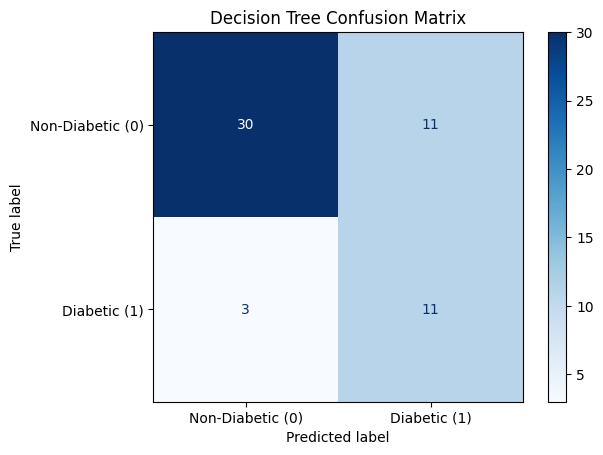

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#confusion matrix for decision tree:

# Compute confusion matrix:
cm = confusion_matrix(y_test, y_pred_best_dt)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Diabetic (0)", "Diabetic (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.show()


In [73]:
#saving decision tree as final model:
import joblib

# Save the model
joblib.dump(best_dt, "diabetes_pipeline_model.pkl")
print("Model saved as diabetes_pipeline_model.pkl")


Model saved as diabetes_pipeline_model.pkl


In [74]:

# Load the model for predictions
loaded_model = joblib.load("diabetes_pipeline_model.pkl")

# Example: Make a prediction on new data
sample_data = [[120, 30, 35, 2, 0.5, 1, 0, 1, 0]]  # Replace with real values
prediction = loaded_model.predict(sample_data)
print("Predicted Outcome:", prediction)


Predicted Outcome: [0.]


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### FEATURE IMPORTANCE ANALYSIS

/tmp/ipykernel_8967/434407275.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[sorted_idx], y=features[sorted_idx], palette="Blues_r")


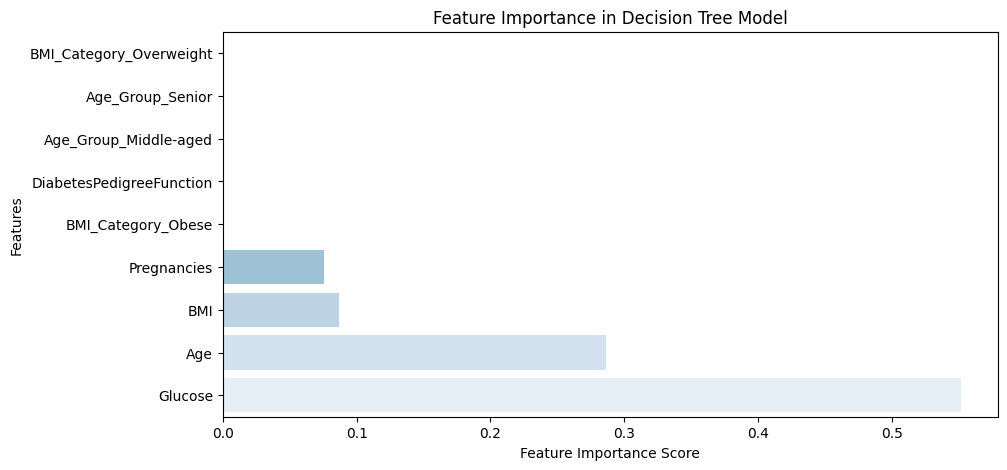

In [75]:


# Get feature importance scores
feature_importance = best_dt.feature_importances_
features = np.array(X_train.columns)

# Sort features by importance
sorted_idx = np.argsort(feature_importance)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance[sorted_idx], y=features[sorted_idx], palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree Model")
plt.show()


## Key Takeaways:
### Glucose is the strongest predictor of diabetes.
### Age and BMI are also crucial for diabetes prediction.
### Pregnancies have some influence, but other categorical features (BMI Category, Age Group) contribute minimally.

In [76]:
### sql script for database creation

In [77]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("diabetes_predictions.db")
cursor = conn.cursor()

# Define the SQL script
sql_script = """
CREATE TABLE Users (
    user_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL
);

CREATE TABLE Predictions (
    prediction_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER,
    glucose FLOAT NOT NULL,
    bmi FLOAT NOT NULL,
    pregnancies INTEGER NOT NULL,
    diabetes_risk FLOAT NOT NULL,
    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (user_id) REFERENCES Users(user_id)
);
"""

# Execute script
cursor.executescript(sql_script)

# Commit and close
conn.commit()
conn.close()

print(" Database and tables created successfully!")


 Database and tables created successfully!
